## Implementing RNN for seattle weather dataset (first dataset)
---

## Importing Libraries and loading the dataset
---

In [83]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "seattle-weather.csv" 
data = pd.read_csv(file_path)
print(f"Original Precipitation Min: {data['precipitation'].min()}")
print(f"Original Precipitation Max: {data['precipitation'].max()}")
rain_with_no_precipitation = data[(data['weather'] == 'rain') & (data['precipitation'] == 0.0)]
print(f"Number of 'rain' days with 0.0 precipitation: {len(rain_with_no_precipitation)}")
print(f"Total 'rain' days: {len(data[data['weather'] == 'rain'])}")


Original Precipitation Min: 0.0
Original Precipitation Max: 55.9
Number of 'rain' days with 0.0 precipitation: 44
Total 'rain' days: 641


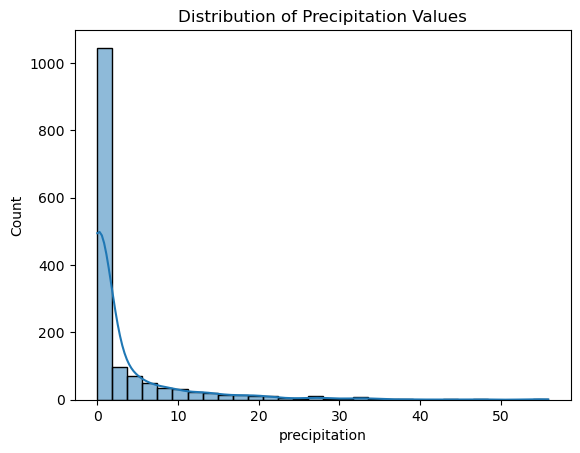

In [80]:
#Analyze data distribution
sns.histplot(data['precipitation'], bins=30, kde=True)
plt.title("Distribution of Precipitation Values")
plt.show()

### **Restructure the Dataset into Time Series format**

---

In [73]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Encode weather, it will be part of our features
label_encoder = LabelEncoder()
data['weather_encoded'] = label_encoder.fit_transform(data['weather'])

# Normalize precipitation column
precipitation_scaler = MinMaxScaler()
data['precipitation_scaled'] = precipitation_scaler.fit_transform(data[['precipitation']])

# Normalize features
features_to_scale = ['temp_max', 'temp_min', 'wind', 'weather_encoded']
scaler = MinMaxScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

# Sequence length
seq_length = 7

X, y = [], []
for i in range(len(data) - seq_length):
    X.append(data[features_to_scale].iloc[i:i+seq_length].values)
    y.append(data['precipitation_scaled'].iloc[i+seq_length]) # Our tagert is precipitation this time

X = np.array(X)
y = np.array(y)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (1460, 1, 4)
Shape of y: (1460,)


### **Split the Data into Training and Testing Sets**

---

In [74]:
# Split the data, 20% testing and 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Build the RNN Model**
Using LSTM for RNN layer, test GRU layer later

---

In [75]:
# Build the RNN model
rnn_model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    SimpleRNN(32, activation='tanh', return_sequences=False),
    Dropout(0.3),  # Dropout to prevent overfitting
    Dense(1)  # Single neuron for regression
])
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print(rnn_model.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)             │ (None, 32)                  │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

None


### **Compile and Train the Model** 

---

In [76]:
history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0595 - mae: 0.1888 - val_loss: 0.0161 - val_mae: 0.0781
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0410 - mae: 0.1548 - val_loss: 0.0134 - val_mae: 0.0652
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 - mae: 0.1136 - val_loss: 0.0133 - val_mae: 0.0782
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - mae: 0.1056 - val_loss: 0.0131 - val_mae: 0.0763
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - mae: 0.0947 - val_loss: 0.0127 - val_mae: 0.0649
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - mae: 0.0889 - val_loss: 0.0128 - val_mae: 0.0633
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - mae: 0.0855 - val_loss: 0.0126 - val_mae: 0.0664
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - mae: 0.0849 - val_loss: 0.0130 - val_mae: 0.0625
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.014

### **Evaluation Metrics**

---

In [77]:
# Evaluation metrics
test_loss, test_mae = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Loss (MSE): {test_loss:.4f}")
print(f"MAE: {test_mae:.4f}")

Loss (MSE): 0.0128
MAE: 0.0656


### **Plots**

---

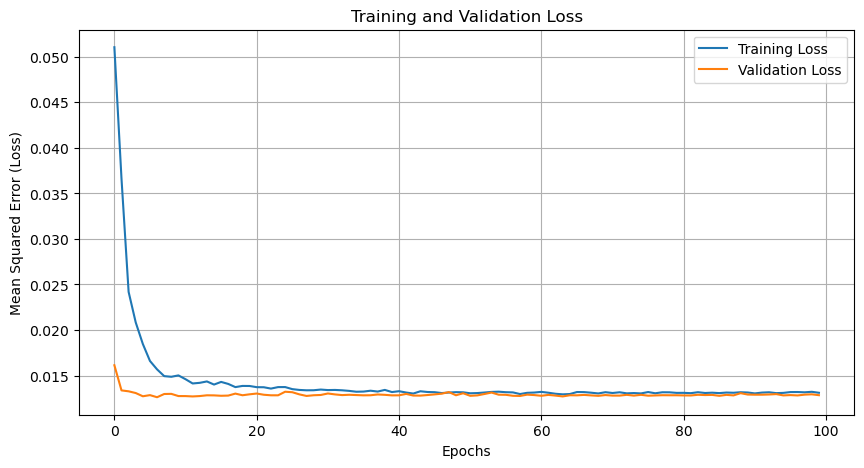

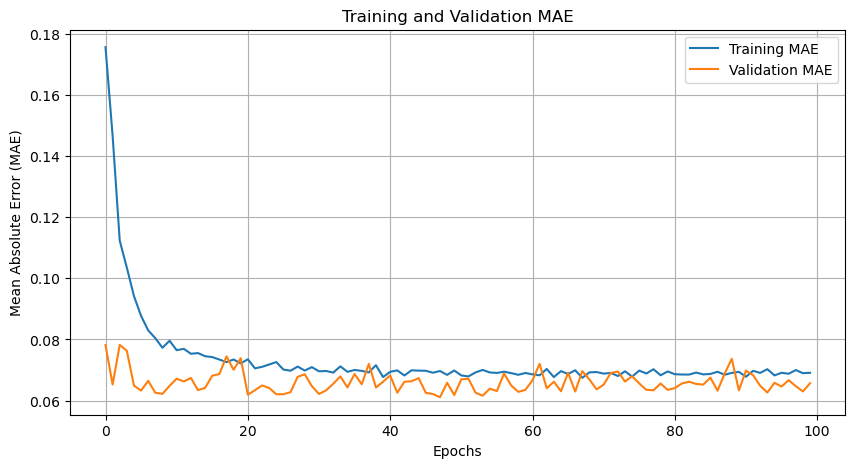

In [78]:
# Plotting MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()